#### Here we run benchmark causal discovery algorithms on the big ER graph and connectome graph.

In [1]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import Notears

2024-05-31 12:51:43,261 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-05-31 12:51:43,352 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [2]:
# load the weighted adjacency matrices for ER and connectome
import numpy as np
import os

# Function to load the adjacency matrix
def load_adjacency_matrix(file_name):
    adj_matrix = np.load(file_name)
    print(f"Adjacency matrix loaded from {file_name}")
    return adj_matrix

# Specify the folder where the adjacency matrices were saved
folder = './data/'

# Example usage to load the saved adjacency matrices
G_A_init_t_ordered_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_adj_matrix.npy'))
G_A_init_t_ordered_dag_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_dag_adj_matrix.npy'))
ER_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'ER_adj_matrix.npy'))
ER_dag_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'ER_dag_adj_matrix.npy'))

Adjacency matrix loaded from ./data/G_A_init_t_ordered_adj_matrix.npy
Adjacency matrix loaded from ./data/G_A_init_t_ordered_dag_adj_matrix.npy
Adjacency matrix loaded from ./data/ER_adj_matrix.npy
Adjacency matrix loaded from ./data/ER_dag_adj_matrix.npy


2024-05-31 12:55:02,019 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-05-31 12:55:02,077 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=2000, d=279, iter_=100, h_=1e-08, rho_=1e+16
2024-05-31 12:55:14,619 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=4.869e-03, loss=31886407951930343424.000, rho=1.0e+00
2024-05-31 12:55:17,415 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=4.869e-03, loss=5521094.826, rho=1.0e+00
2024-05-31 12:55:20,777 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=4.869e-03, loss=5521094.8

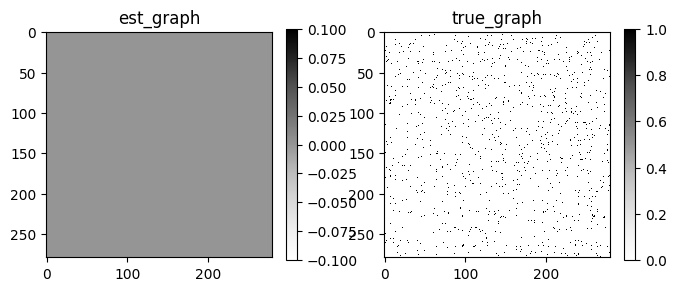

{'fdr': 0.0, 'tpr': 0.0, 'fpr': 0.0, 'shd': 1548, 'nnz': 0, 'precision': nan, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}


/users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


In [4]:
# simulate data for notears
dataset = IIDSimulation(W=ER_dag_adj_matrix, n=2000, method='linear', sem_type='gauss')
true_dag, X = dataset.B, dataset.X

# notears learn
nt = Notears()
nt.learn(X)

# plot est_dag and true_dag
GraphDAG(nt.causal_matrix, true_dag)

# calculate accuracy
met = MetricsDAG(nt.causal_matrix, true_dag)
print(met.metrics)